In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as sp
import findiff as fd

In [3]:
lj_sigma = 1.46
lj_eps = 0.405

In [4]:
def f_lj(r):
    a = lj_sigma / r
    return 4 * lj_eps * (np.pow(a, 12) - np.pow(a, 6))

In [5]:
def scatter(X, Y, cond):
    X = X[cond]
    Y = Y[cond]
    plt.scatter(X, Y)
    for i, txt in enumerate(zip(X,Y)):
        txt = f"{txt[0]:.3f}, {txt[1]:.3f}"
        plt.annotate(txt, (X[i], Y[i]))

In [6]:
def scatter_one(x, y):
    plt.scatter(x, y)
    txt = f"{x:.3f}, {y:.3f}"
    plt.annotate(txt, (x, y))

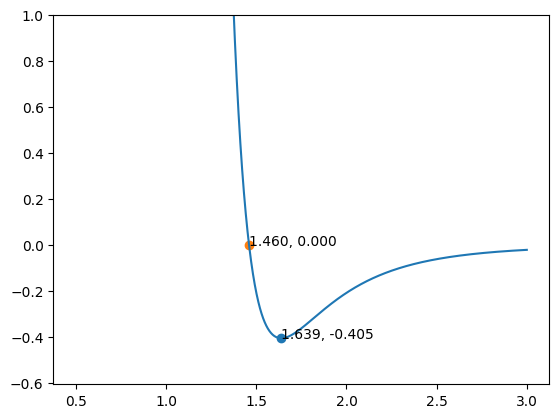

In [7]:
R = np.linspace(0.5, 3, 2000)
E = f_lj(R)

plt.plot(R, E)
plt.ylim((E.min() -0.2, 1))

scatter(R, E, E == E.min())
scatter_one(lj_sigma, f_lj(lj_sigma))

In [8]:
zbl_Z1 = 6
zbl_Z2 = 14
zbl_eps0 = 55.26349406 * 1e-4
zbl_eps0

0.005526349406

In [9]:
def f_phi(x):
    c1 = 0.02817
    c2 = 0.28022
    c3 = 0.50986
    c4 = 0.18175
    d1 = 0.20162
    d2 = 0.40290
    d3 = 0.94229
    d4 = 3.19980
    e1 = np.exp(-d1*x)
    e2 = np.exp(-d2*x)
    e3 = np.exp(-d3*x)
    e4 = np.exp(-d4*x)
    return c1*e1 + c2*e2 + c3*e3 * c4*e4

def f_zbl(r):
    a = 0.4685 / (np.pow(zbl_Z1, 0.23) + np.pow(zbl_Z2, 0.23))
    phi = f_phi(r / a)
    E = 1.6 * 9 * zbl_Z1 * zbl_Z2 / r
    E *= phi
    return E

(-0.8285056202966994, 100.0)

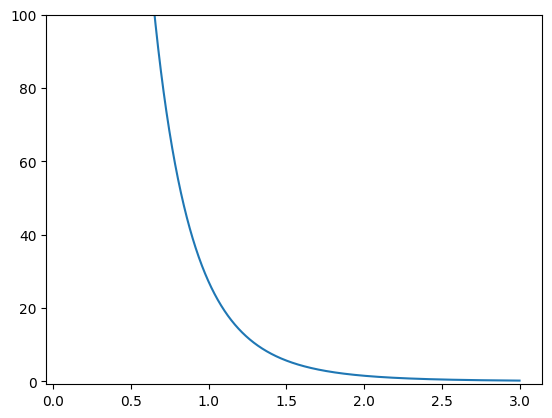

In [10]:
R = np.linspace(0.1, 3, 2000)
E = f_zbl(R)

plt.plot(R, E)
plt.ylim((E.min() - 1, 100))

(1.0, 1.5)

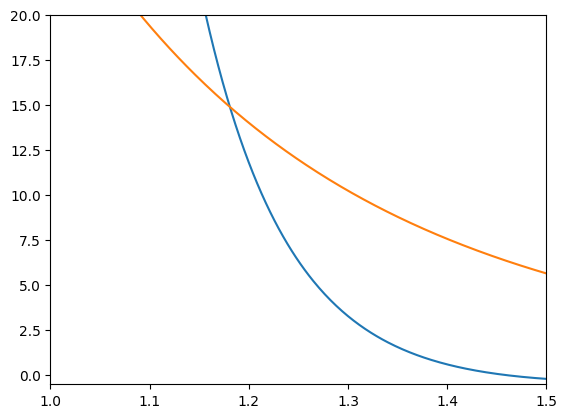

In [11]:
R = np.linspace(0.1, 3, 2000)
E_zbl = f_zbl(R)
E_lj = f_lj(R)

plt.plot(R, E_lj)
plt.plot(R, E_zbl)
plt.ylim((E_lj.min() -0.1, 20))
plt.xlim((1, 1.5))

(-1.0, 100.0)

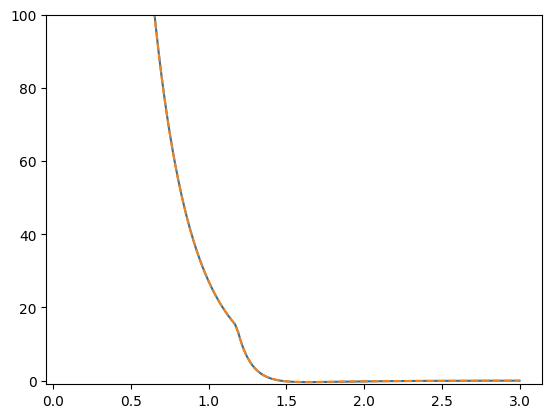

In [61]:
R_1 = np.linspace(0.1, 1.17, 1000)
R_2 = np.linspace(1.19, 3, 2000)
R = np.append(R_1, R_2)
E_ljzbl = f_zbl(R_1)
E_ljzbl = np.append(E_ljzbl, f_lj(R_2))
#for i in range(3, 5):
#    p_coeffs = np.polyfit(R, E_ljzbl, i)
#    p_fit = np.poly1d(p_coeffs)
#    new_E = p_fit(R)
#    plt.plot(R, new_E, '--')
spl = sp.CubicSpline(R, E_ljzbl)
new_E = spl(R)

plt.plot(R, E_ljzbl)
plt.plot(R, new_E, '--')
plt.ylim((-1, 100))
#plt.xlim((1, 1.5))

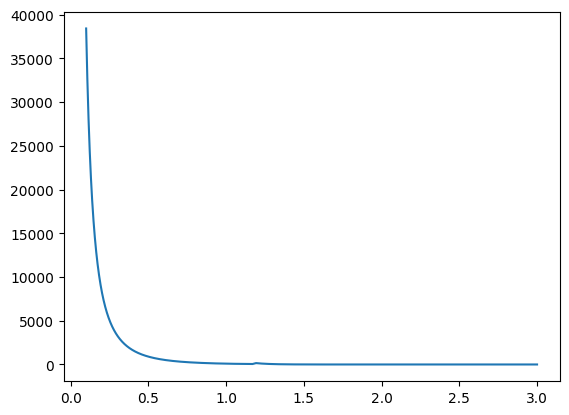

In [63]:
R = np.linspace(0.1, 3, 3000)
N = np.linspace(1, R.shape[0], R.shape[0])
E_sp = spl(R)
d_x = R[2] - R[1]
dev = fd.FinDiff(0, d_x)
F_sp = -1 * dev(E_sp)

plt.plot(R, F_sp)
#plt.xlim((1, 1.5))
#plt.ylim((-1,200))
np.savetxt("E_ljzbl.txt", np.c_[N, R, E_sp, F_sp])

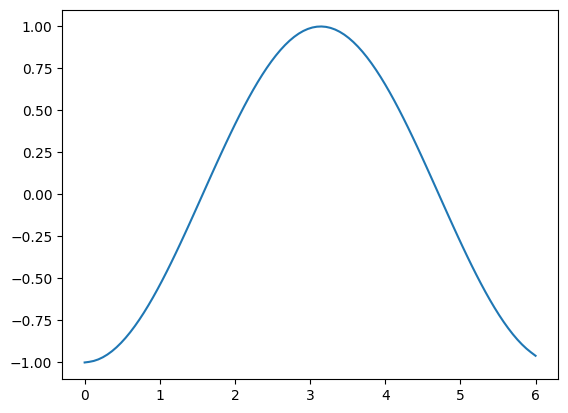

In [68]:
R = np.linspace(0, 6, 100)
d_x = R[1] - R[0]
E = np.sin(R)
dev = fd.FinDiff(0, d_x)
F_sp = -1 * dev(E)
plt.plot(R, F_sp)